In [1]:
from IPython.display import display, HTML
display(HTML("""<style>.container { width:90% !important; }.text_cell_render, .output_text {font-family: Lato;font-size: 18px;line-height: 1.5;}.CodeMirror {font-size: 16px;}</style>"""))
from quiz.jupyterquiz import display_quiz

# Module 3

## Autograd, your companion for all your gradient needs!

Autograd is PyTorch’s *automatic differentiation package*. Thanks to it, we **don’t need to worry** about partial derivatives, chain rule or anything like it.

<h2><b><i>Computing gradients manually?! No way! Backward!</b></i></h2>


### backward

So, how do we tell PyTorch to do its thing and **compute all gradients**? That’s what [**backward()**](https://bit.ly/3eV9Dub) is good for.

Do you remember the **starting point** for **computing the gradients**? It was the **loss**, as we computed its partial derivatives w.r.t. our parameters. Hence, we need to invoke the `backward()` method from the corresponding Python variable, like, `loss.backward()`.

In [66]:
# Step 0
torch.manual_seed(42)

b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

In [67]:
# Step 1
# Computes our model's predicted output
yhat = b + w * x_train_tensor

# Step 2    
# How wrong is our model? That's the error! 
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# Step 3    
# No more manual computation of gradients! 
loss.backward()

# Computes gradients for both "b" and "w" parameters
# b_grad = 2 * error.mean()
# w_grad = 2 * (x_train_tensor * error).mean()

### grad / zero_


What about the **actual values** of the **gradients**? We can inspect them by looking at the [**grad**](https://bit.ly/3fYtNFa) **attribute** of a tensor.

In [68]:
print(b.grad, w.grad)

tensor([-3.3881], device='cuda:0') tensor([-1.9439], device='cuda:0')


If you check the method’s documentation, it clearly states that **gradients are accumulated**. 

You can check this out by running the two code cells above again.

So, every time we use the **gradients** to **update** the parameters, we need to **zero the gradients afterwards**. And that’s what [**zero_()**](https://pytorch.org/docs/stable/generated/torch.Tensor.zero_.html#torch.Tensor.zero_) is good for.

---

*In PyTorch, every method that **ends** with an **underscore (_)** makes changes **in-place**, meaning, they will **modify** the underlying variable.*

---

In [69]:
b.grad.zero_(), w.grad.zero_()

(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))

So, let’s **ditch** the **manual computation of gradients** and use both `backward()` and `zero_()` methods instead.

And, we are still missing **Step 4**, that is, **updating the parameters**. Let's include it as well...

In [70]:
# Step 0
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Step 1
# Computes our model's predicted output
yhat = b + w * x_train_tensor

# Step 2    
# How wrong is our model? That's the error! 
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# Step 3    
# No more manual computation of gradients! 
loss.backward()
# Computes gradients for both "b" and "w" parameters
# b_grad = 2 * error.mean()
# w_grad = 2 * (x_train_tensor * error).mean()
print(b.grad, w.grad)

# Step 4
# Updates parameters using gradients and the learning rate
with torch.no_grad(): # what is that?!
    b -= lr * b.grad
    w -= lr * w.grad

# PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
b.grad.zero_()
w.grad.zero_()

print(b.grad, w.grad)

tensor([-3.3881], device='cuda:0') tensor([-1.9439], device='cuda:0')
tensor([0.], device='cuda:0') tensor([0.], device='cuda:0')


### no_grad

<h2><b><i>"One does not simply update parameters without no_grad"</b></i></h2>

Why do we need to use [**no_grad()**](https://bit.ly/39o0nh4) to **update the parameters**?

The culprit is PyTorch’s ability to build a **dynamic computation graph** from every **Python operation** that involves any **gradient-computing tensor** or its **dependencies**.

---

**What is a dynamic computation graph?**

Don't worry, we’ll go deeper into the inner workings of the dynamic computation graph in the next section.

---

So, how do we tell PyTorch to “**back off**” and let us **update our parameters** without messing up with its **fancy dynamic computation graph**? 


That is the purpose of **no_grad()**: it allows us to **perform regular Python operations on tensors, independent of PyTorch’s computation graph**.

In [71]:
lr = 1e-1
n_epochs = 1000

# Step 0
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    # Step 1
    # Computes our model's predicted output
    yhat = b + w * x_train_tensor

    # Step 2    
    # How wrong is our model? That's the error! 
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3    
    # No more manual computation of gradients! 
    loss.backward()

    # Step 4
    # Updates parameters using gradients and the learning rate
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad

    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    b.grad.zero_()
    w.grad.zero_()

print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


Finally, we managed to successfully run our model and get the **resulting parameters**. Surely enough, they **match** the ones we got in our *Numpy*-only implementation.

Let's take a look at the **loss** at the end of the training...

In [72]:
loss

tensor(0.0080, device='cuda:0', grad_fn=<MeanBackward0>)

What if we wanted to have it as a *Numpy* array? I guess we could just use **numpy()** again, right? (and **cpu()** as well, since our *loss* is in the `cuda` device...

In [73]:
loss.cpu().numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

What happened here? Unlike our *data tensors*, the **loss tensor** is actually computing gradients - and in order to use **numpy**, we need to [**detach()**](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html#torch.Tensor.detach) that tensor from the computation graph first:

In [74]:
loss.detach().cpu().numpy()

array(0.00804466, dtype=float32)

This seems like **a lot of work**, there must be an easier way! And there is one indeed: we can use [**item()**](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item), for **tensors with a single element** or [**tolist()**](https://pytorch.org/docs/stable/generated/torch.Tensor.tolist.html#torch.Tensor.tolist) otherwise.

In [75]:
print(loss.item(), loss.tolist())

0.008044655434787273 0.008044655434787273


## Dynamic Computation Graph: what is that?

<h2><b><i>"No one can be told what the dynamic computation graph is - you have to see it for yourself"</b></i></h2>

Jokes aside, I want **you** to **see the graph for yourself** too!

The [PyTorchViz](https://github.com/szagoruyko/pytorchviz) package and its `make_dot(variable)` method allows us to easily visualize a graph associated with a given Python variable.

So, let’s stick with the **bare minimum**: two (gradient computing) **tensors** for our parameters, predictions, errors and loss.

In [76]:
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = b + w * x_train_tensor
error = yhat - y_train_tensor
loss = (error ** 2).mean()

Now let's plot the **computation graph** for the **yhat** variable.

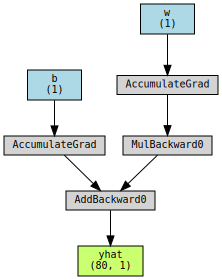

In [77]:
make_dot(yhat, params={'b': b, 'w': w, 'yhat': yhat})

Let’s take a closer look at its components:

* **blue boxes**: these boxes correspond to the **tensors** we use as **parameters**, the ones we’re asking PyTorch to **compute gradients** for;

* **gray box**: a **Python operation** that involves a **gradient-computing tensor or its dependencies**;

* **green box**: the tensor used as the **starting point for the computation** of gradients (assuming the **`backward()`** method is called from the **variable used to visualize** the graph)— they are computed from the **bottom-up** in a graph.

Now, take a closer look at the **gray box** at the bottom of the graph: there are **two arrows** pointing to it, since it is **adding up two variables**, `b` and `w*x`. Seems obvious, right?

Then, look at the **gray box** (`MulBackwardo0`) of the same graph: it is performing a **multiplication**, namely, `w*x`. But there is only **one arrow** pointing to it! The arrow comes from the **blue box** that corresponds to our parameter `w`.

Why don’t we have a box for our **data x**? The answer is: **we do not compute gradients for it**! So, even though there are *more* tensors involved in the operations performed by the computation graph, it **only** shows **gradient-computing tensors and its dependencies**.

Try using the `make_dot` method to plot the **computation graph** of other variables, like `error` or `loss`.

The **only difference** between them and the first one is the number of **intermediate steps (gray boxes)**.



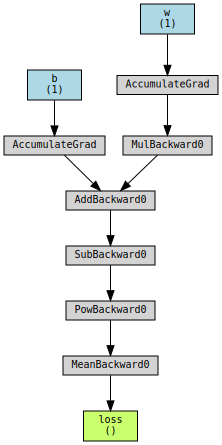

In [78]:
make_dot(loss, params={'b': b, 'w': w, 'loss': loss})

What would happen to the computation graph if we set **`requires_grad`** to **`False`** for our parameter **`b`**?

In [79]:
b_nograd = torch.randn(1, requires_grad=False, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = b_nograd + w * x_train_tensor

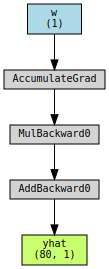

In [80]:
make_dot(yhat, params={'b': b_nograd, 'w': w, 'yhat': yhat})

Unsurprisingly, the **blue box** corresponding to the **parameter a** is no more! 

Simple enough: **no gradients, no graph**.

The **best thing** about the *dynamic computing graph* is the fact that you can make it **as complex as you want it**. You can even use *control flow statements* (e.g., if statements) to **control the flow of the gradients** (obviously!) :-)

Let's build a nonsensical, yet complex, computation graph just to make a point!

In [81]:
yhat = b + w * x_train_tensor
error = yhat - y_train_tensor

loss = (error ** 2).mean()

if loss > 0:
    yhat2 = w * x_train_tensor
    error2 = y_train_tensor - yhat2

loss += error2.mean()

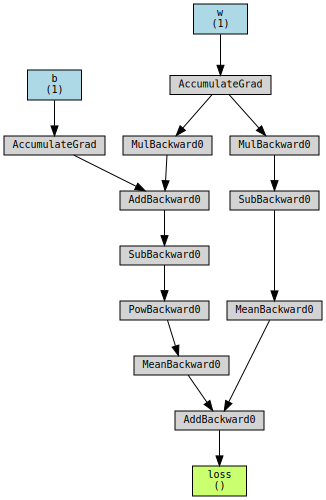

In [82]:
make_dot(loss, params={'b': b, 'w': w, 'loss': loss})

## Optimizer:  learning the parameters step-by-step

So far, we’ve been **manually** updating the parameters using the computed gradients. That’s probably fine for *two parameters*… but what if we had a **whole lot of them**?! We use one of PyTorch’s **optimizers**, like [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) or [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

---

There are **many** optimizers, **SGD** is the most basic of them and **Adam** is one of the most popular. They achieve the same goal through, literally, **different paths**.

---

![](images/sgd_adam_paths.png)

![](images/sgd_nesterov_paths.png)

In the code below, we create a *Stochastic Gradient Descent* (SGD) optimizer to update our parameters **b** and **w**.

---

Don’t be fooled by the **optimizer’s** name: if we use **all training data** at once for the update — as we are actually doing in the code — the optimizer is performing a **batch** gradient descent, despite of its name.

---

In [83]:
# Our parameters
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Learning rate
lr = 1e-1

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

### step / zero_grad

An optimizer takes the **parameters** we want to update, the **learning rate** we want to use (and possibly many other hyper-parameters as well!) and **performs the updates** through its [**`step()`**](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step) method.

Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s [**`zero_grad()`**](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html#torch.optim.Optimizer.zero_grad) method and that’s it!

In [84]:
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1
    yhat = b + w * x_train_tensor

    # Step 2
    error = yhat - y_train_tensor
    loss = (error ** 2).mean()

    # Step 3
    loss.backward()    
    
    # Step 4
    # No more manual update!
    # with torch.no_grad():
    #     b -= lr * b.grad
    #     w -= lr * w.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # b.grad.zero_()
    # w.grad.zero_()
    optimizer.zero_grad()

print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


Cool! We’ve *optimized* the **optimization** process :-) What’s left?

## Loss: aggregating erros into a single value

We now tackle the **loss computation**. As expected, PyTorch got us covered once again. There are many [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) to choose from, depending on the task at hand. Since ours is a regression, we are using the [Mean Squared Error (MSE)](https://bit.ly/3hNYn4R) loss.

---

Notice that `nn.MSELoss` actually **creates a loss function** for us — **it is NOT the loss function itself**. Moreover, you can specify a **reduction method** to be applied, that is, **how do you want to aggregate the results for individual points** — you can average them (reduction=’mean’) or simply sum them up (reduction=’sum’).

---

In [85]:
# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

loss_fn

MSELoss()

In [86]:
fake_labels = torch.tensor([1., 2., 3.])
fake_preds = torch.tensor([1., 3., 5.])

loss_fn(fake_preds, fake_labels)

tensor(1.6667)

We then **use** the created loss function to compute the loss given our **predictions** and our **labels**.

In [87]:
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([b, w], lr=lr)

for epoch in range(n_epochs):
    # Step 1
    yhat = b + w * x_train_tensor
    
    # Step 2
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3
    loss.backward() 

    # Step 4
    optimizer.step()
    optimizer.zero_grad()
    
print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


At this point, there’s only one piece of code left to change: the **predictions**.

## Quiz

In [88]:
display_quiz('#./quiz/quiz3.b64')

# Exercise #3